# 深圳杯B题

## 第一问

In [2]:
import numpy as np
import colour
from scipy.optimize import minimize, LinearConstraint, Bounds, NonlinearConstraint

# 获取 BT.2020 色彩空间对象
bt2020 = colour.RGB_COLOURSPACES['ITU-R BT.2020']
srgb = colour.RGB_COLOURSPACES['sRGB']

# 随机采样 RGB（属于 BT.2020 空间的 RGB 向量）
rgb_bt2020 = np.random.rand(1000, 3)
print(rgb_bt2020.shape)

# 将 RGB（BT.2020）转换为 XYZ
xyz_bt2020 = colour.RGB_to_XYZ(
    rgb_bt2020,
    bt2020.whitepoint,
    bt2020.whitepoint,
    bt2020.matrix_RGB_to_XYZ
)

# 将 XYZ 转换为 sRGB 空间的 RGB
rgb_srgb = colour.XYZ_to_RGB(
    xyz_bt2020,
    srgb.whitepoint,
    srgb.whitepoint,
    srgb.matrix_XYZ_to_RGB
)

# 可选：裁剪到 sRGB 显示范围 [0, 1]
rgb_srgb_clipped = np.clip(rgb_srgb, 0, 1)

# 检查有多少点本来就在 sRGB 色域内
in_gamut = np.all((rgb_srgb >= 0) & (rgb_srgb <= 1), axis=1)
print(f"{np.sum(in_gamut)} / {len(rgb_srgb)} colors are in sRGB gamut.")

def objective(M_flat):
    M = M_flat.reshape(3, 3)
    xyz_srgb = (M @ xyz_bt2020.T).T  # Apply M
    rgb_srgb = colour.XYZ_to_RGB(
        xyz_srgb,
        srgb.whitepoint,
        srgb.whitepoint,
        srgb.matrix_XYZ_to_RGB
    )
    lab_target = colour.XYZ_to_Lab(xyz_bt2020)
    lab_result = colour.XYZ_to_Lab(xyz_srgb)
    delta_E = colour.delta_E(lab_target, lab_result, method='CIE 2000')
    return np.mean(delta_E)

def gamut_constraint(M_flat):
    M = M_flat.reshape(3, 3)
    xyz_srgb = (M @ xyz_bt2020.T).T
    rgb_srgb = colour.XYZ_to_RGB(
        xyz_srgb,
        srgb.whitepoint,
        srgb.whitepoint,
        srgb.matrix_XYZ_to_RGB
    )
    # 返回距离越界的最小 margin（负数代表不合法）
    return np.min(np.minimum(rgb_srgb, 1 - rgb_srgb))

# 初始猜测为单位矩阵
M0 = np.eye(3).flatten()

# 非线性约束：所有 RGB 分量必须 ∈ [0, 1]
nonlinear_constraint = NonlinearConstraint(gamut_constraint, -0.01, np.inf)
# 原本的约束条件过于严苛了，这里放宽了标准
print(f"deltaE: {objective(M0)}")

result = minimize(objective, M0, constraints=[nonlinear_constraint])
print(f"Optimization success: {result.success}")
print(f"Optimized matrix M:\n{result.x.reshape(3, 3)}")
print(f"deltaE: {result.fun}")
print(f"Optimization message: {result.message}")

# 获取色彩空间
bt2020 = colour.RGB_COLOURSPACES['ITU-R BT.2020']
srgb = colour.RGB_COLOURSPACES['sRGB']

# 使用您已经优化好的矩阵M
M = result.x.reshape(3, 3)

# 在BT.2020 RGB空间中均匀采样
samples = 100000
np.random.seed(42)  # 设置随机种子以确保结果可复现
rgb_bt2020 = np.random.rand(samples, 3)

# 将RGB(BT.2020)转换为XYZ
xyz_bt2020 = colour.RGB_to_XYZ(
    rgb_bt2020,
    bt2020.whitepoint,
    bt2020.whitepoint,
    bt2020.matrix_RGB_to_XYZ
)

# 计算优化前：直接将BT.2020 XYZ转换为sRGB
rgb_srgb_direct = colour.XYZ_to_RGB(
    xyz_bt2020,
    srgb.whitepoint,
    srgb.whitepoint,
    srgb.matrix_XYZ_to_RGB
)
in_gamut_before = np.all((rgb_srgb_direct >= 0) & (rgb_srgb_direct <= 1), axis=1)
coverage_before = np.sum(in_gamut_before) / samples * 100

# 计算优化后：应用优化矩阵M，然后转换为sRGB
xyz_transformed = (M @ xyz_bt2020.T).T
rgb_srgb_optimized = colour.XYZ_to_RGB(
    xyz_transformed,
    srgb.whitepoint,
    srgb.whitepoint,
    srgb.matrix_XYZ_to_RGB
)
in_gamut_after = np.all((rgb_srgb_optimized >= 0) & (rgb_srgb_optimized <= 1), axis=1)
coverage_after = np.sum(in_gamut_after) / samples * 100

# 输出结果
print(f"采样点数: {samples}")
print(f"优化前色域覆盖率: {coverage_before:.2f}%")
print(f"优化后色域覆盖率: {coverage_after:.2f}%")
print(f"覆盖率变化: {coverage_after - coverage_before:.2f}%")

(1000, 3)
493 / 1000 colors are in sRGB gamut.
deltaE: 0.0


e:\ANACONDA\envs\colour\lib\site-packages\colour\utilities\verbose.py:322: ColourUsageWarning: The "colour.RGB_to_XYZ" definition signature has changed with "Colour 0.4.3". The used call arguments are deprecated, please refer to the documentation for more information about the new signature.
  warn(*args, **kwargs)  # noqa: B028
e:\ANACONDA\envs\colour\lib\site-packages\colour\utilities\verbose.py:322: ColourUsageWarning: The "colour.XYZ_to_RGB" definition signature has changed with "Colour 0.4.3". The used call arguments are deprecated, please refer to the documentation for more information about the new signature.
  warn(*args, **kwargs)  # noqa: B028


Optimization success: True
Optimized matrix M:
[[  4.82483042e-01   4.12727942e-01   6.79986785e-02]
 [ -1.27377170e-01   1.08682132e+00   2.93636549e-02]
 [  3.72085953e-05   1.22196430e-01   8.72151150e-01]]
deltaE: 6.241111320832432
Optimization message: Optimization terminated successfully
采样点数: 100000
优化前色域覆盖率: 49.64%
优化后色域覆盖率: 96.77%
覆盖率变化: 47.13%


## 第二问

### 四基色视频源RGBV

In [3]:
import numpy as np
import colour
import matplotlib.path as mpath
from scipy.optimize import minimize
from scipy.spatial import ConvexHull

print(colour.__version__)
# BT.2020前三基色xy
bt2020_xy = np.array([
    [0.708, 0.292],  # R
    [0.170, 0.797],  # G
    [0.131, 0.046],  # B
])

# 获取CIE 1931马蹄形边界
def get_spectral_locus():
    # 获取CIE 1931标准观察者
    cmfs = colour.MSDS_CMFS['CIE 1931 2 Degree Standard Observer']
    
    # 过滤波长范围在360-780nm之间的值
    valid_mask = (cmfs.wavelengths >= 360) & (cmfs.wavelengths <= 780)
    valid_wavelengths = cmfs.wavelengths[valid_mask]
    
    # 直接从波长计算xy坐标
    XYZ = colour.wavelength_to_XYZ(valid_wavelengths)
    xy = colour.XYZ_to_xy(XYZ)
    
    # 添加紫线（连接最短和最长波长的点）以闭合马蹄形
    xy = np.vstack([xy, xy[0]])
    
    return xy

# 创建马蹄形路径
horseshoe_boundary = get_spectral_locus()
horseshoe_path = mpath.Path(horseshoe_boundary)
# 检查闭合情况
is_closed = np.allclose(horseshoe_boundary[0], horseshoe_boundary[-1])
print(f"马蹄形边界是否闭合: {is_closed}")


def horseshoe_constraint(xy):
    inside = horseshoe_path.contains_point(xy)
    # 简单计算到所有边界点的最小距离作为近似
    distances = np.linalg.norm(horseshoe_boundary - xy, axis=1)
    min_dist = np.min(distances) / 10  # 缩放系数使值适中
    return min_dist if inside else -min_dist


def polygon_area(points):
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]
    x = hull_points[:, 0]
    y = hull_points[:, 1]
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

def objective(xy):
    # 目标函数：负面积（因为 minimize 是最小化）
    points = np.vstack([bt2020_xy, xy])
    return -polygon_area(points)

# 定义约束
constraints = [
    {'type': 'ineq', 'fun': horseshoe_constraint}
]

# 初始猜测
x0 = np.array([0.1, 0.6])

# 执行优化
result = minimize(objective, x0, method='SLSQP', constraints=constraints)

# 计算马蹄形图形的面积
horseshoe_area = polygon_area(horseshoe_boundary)
print(f"马蹄形图形的面积：{horseshoe_area}")
print(f"原来的三角形面积：{polygon_area(bt2020_xy)}")

if horseshoe_path.contains_point((0.03,0.65)):
    print("在马蹄形中")
print(f"猜测面积：{-objective((0.03,0.65))}")

if result.success:
    best_xy = result.x
    best_area = -result.fun
    print(f"最佳第四通道基色xy：{best_xy}, 覆盖面积：{best_area}")
    print(f"覆盖比例{best_area/horseshoe_area*100}%")
else:
    print("优化失败:", result.message)

0.4.6
马蹄形边界是否闭合: True
马蹄形图形的面积：0.33434752908008214
原来的三角形面积：0.2118665
在马蹄形中
猜测面积：0.26157
最佳第四通道基色xy：[ 0.00385765  0.65483051], 覆盖面积：0.27148064860928445
覆盖比例81.19714518490132%


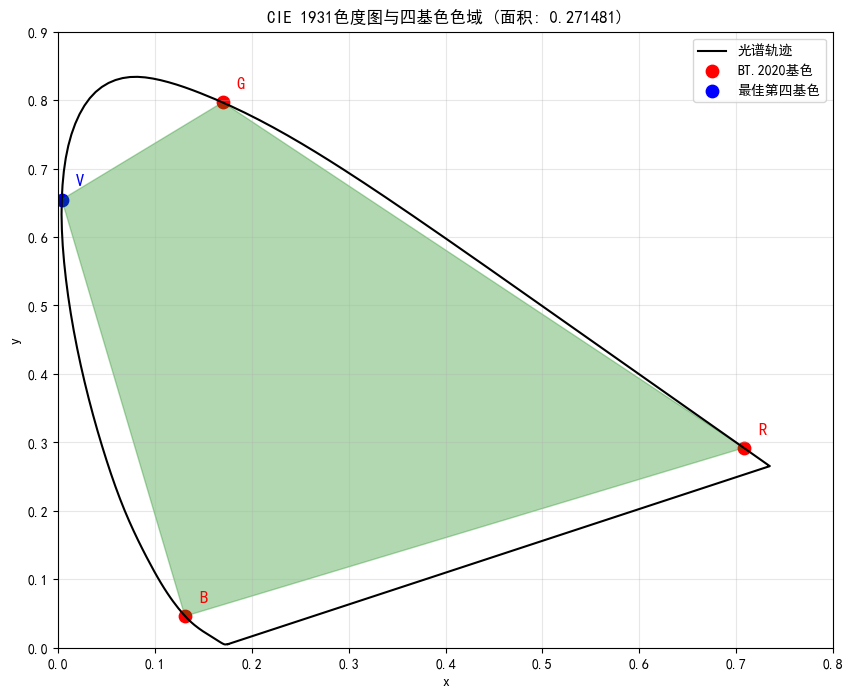

In [4]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from scipy.spatial import ConvexHull
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

"""
原本的测试代码里面的面积计算函数无法正确处理G->V->B->R->G的连接顺序，
当出现这一情况的时候只会把它连成R->G->B->V->R，这样算出来的面积远小于真实值
"""

# 绘制马蹄形和色域多边形
def plot_horseshoe_and_gamut():
    # 创建图形
    plt.figure(figsize=(10, 8))
    
    # 获取马蹄形边界
    horseshoe_boundary = get_spectral_locus()
    
    # 绘制马蹄形边界
    plt.plot(horseshoe_boundary[:, 0], horseshoe_boundary[:, 1], 'k-', label='光谱轨迹')
    
    # 绘制BT.2020三基色
    plt.scatter(bt2020_xy[:, 0], bt2020_xy[:, 1], color='red', s=80, label='BT.2020基色')
    
    # 标注RGB基色
    labels = ['R', 'G', 'B']
    for i, label in enumerate(labels):
        plt.annotate(label, (bt2020_xy[i, 0], bt2020_xy[i, 1]), 
                    xytext=(10, 10), textcoords='offset points', 
                    fontsize=12, color='red')
    
    # 如果有最佳第四基色，绘制它
    if 'best_xy' in globals():
        plt.scatter(best_xy[0], best_xy[1], color='blue', s=80, label='最佳第四基色')
        plt.annotate('V', (best_xy[0], best_xy[1]), 
                    xytext=(10, 10), textcoords='offset points', 
                    fontsize=12, color='blue')
        
        # 绘制四基色形成的色域
        gamut_points = np.vstack([bt2020_xy, [best_xy[0], best_xy[1]]])
        
        # 使用ConvexHull获取正确的点顺序
        hull = ConvexHull(gamut_points)
        hull_vertices = hull.vertices
        # 按照凸包顺序排列点
        ordered_points = gamut_points[hull_vertices]
        
        # 使用排序后的点创建多边形
        gamut_polygon = Polygon(ordered_points, alpha=0.3, color='green', closed=True)
        plt.gca().add_patch(gamut_polygon)
        
        # 计算并显示色域面积
        area = polygon_area(gamut_points)
        plt.title(f'CIE 1931色度图与四基色色域 (面积: {area:.6f})')
    else:
        # 绘制三基色形成的色域
        # 使用ConvexHull确保点的顺序正确
        hull = ConvexHull(bt2020_xy)
        ordered_points = bt2020_xy[hull.vertices]
        
        gamut_polygon = Polygon(ordered_points, alpha=0.3, color='green', closed=True)
        plt.gca().add_patch(gamut_polygon)
        
        # 计算并显示色域面积
        area = polygon_area(bt2020_xy)
        plt.title(f'CIE 1931色度图与BT.2020色域 (面积: {area:.6f})')
    
    # 设置坐标轴范围和标签
    plt.xlim(0, 0.8)
    plt.ylim(0, 0.9)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

# 绘制图形
plot_horseshoe_and_gamut()

### 五基色(通道)的显示屏RGBCX

马蹄形图形的面积：0.334348
原来的三角形面积：0.211867
开始差分进化优化，这可能需要几分钟...
优化成功，最终函数值: -0.288204
最佳第四基色xy：(0.006105, 0.686052)
最佳第五基色xy：(0.193571, 0.013895)
五边形覆盖面积：0.288204
覆盖比例：86.20%


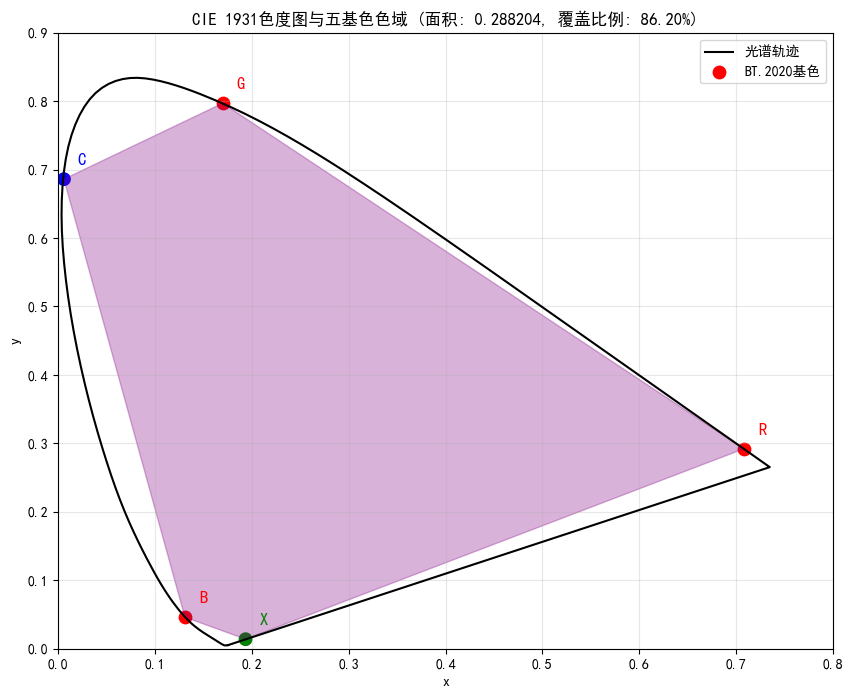

In [5]:
import numpy as np
import colour
import matplotlib.path as mpath
from scipy.optimize import differential_evolution
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

"""
一开始使用SLSQP，发现优化结果很不稳定，还会还不能正确优化第五基点，所以我使用了差分进化优化
"""



# BT.2020前三基色xy
bt2020_xy = np.array([
    [0.708, 0.292],  # R
    [0.170, 0.797],  # G
    [0.131, 0.046],  # B
])

# 获取CIE 1931马蹄形边界
def get_spectral_locus():
    # 获取CIE 1931标准观察者
    cmfs = colour.MSDS_CMFS['CIE 1931 2 Degree Standard Observer']
    
    # 过滤波长范围在360-780nm之间的值
    valid_mask = (cmfs.wavelengths >= 360) & (cmfs.wavelengths <= 780)
    valid_wavelengths = cmfs.wavelengths[valid_mask]
    
    # 直接从波长计算xy坐标
    XYZ = colour.wavelength_to_XYZ(valid_wavelengths)
    xy = colour.XYZ_to_xy(XYZ)
    
    # 添加紫线（连接最短和最长波长的点）以闭合马蹄形
    xy = np.vstack([xy, xy[0]])
    
    return xy

# 创建马蹄形路径
horseshoe_boundary = get_spectral_locus()
horseshoe_path = mpath.Path(horseshoe_boundary)

def polygon_area(points):
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]
    x = hull_points[:, 0]
    y = hull_points[:, 1]
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

# 计算马蹄形面积(用于后续计算覆盖比例)
horseshoe_area = polygon_area(horseshoe_boundary)
print(f"马蹄形图形的面积：{horseshoe_area:.6f}")
print(f"原来的三角形面积：{polygon_area(bt2020_xy):.6f}")

# 定义差分进化的目标函数
def de_objective(x):
    x1, y1, x2, y2 = x
    
    # 检查点是否在马蹄形内
    if not (horseshoe_path.contains_point((x1, y1)) and 
            horseshoe_path.contains_point((x2, y2))):
        return 1000  # 如果点不在马蹄形内，返回一个大的惩罚值
    
    # 计算两点之间的距离
    dist = np.sqrt((x1-x2)**2 + (y1-y2)**2)
    
    # 添加距离惩罚，防止两点重合或过于接近
    # 如果距离小于0.2，添加惩罚
    penalty = 0.05 * max(0, 0.2 - dist)**2
    
    # 计算五边形面积
    points = np.vstack([bt2020_xy, [(x1, y1), (x2, y2)]])
    area = polygon_area(points)
    
    # 返回负面积加惩罚(因为我们要最小化)
    return -area + penalty

# 设置优化边界
bounds = [(0.0, 0.8), (0.0, 0.9), (0.0, 0.8), (0.0, 0.9)]

# 运行差分进化算法
print("开始差分进化优化，这可能需要几分钟...")
result = differential_evolution(
    de_objective, 
    bounds,
    strategy='best1bin',  # 优化策略
    popsize=15,           # 种群大小
    mutation=(0.5, 1.0),  # 变异范围
    recombination=0.7,    # 重组率
    tol=0.01,             # 收敛容差
    maxiter=100,          # 最大迭代次数
    polish=True,          # 使用局部优化polish最终结果
    seed=42               # 随机种子，保证结果可重现
)

# 输出优化结果
if result.success:
    best_xy = result.x
    best_area = -de_objective(best_xy) # 注意转换回正值
    print(f"优化成功，最终函数值: {result.fun:.6f}")
    print(f"最佳第四基色xy：({best_xy[0]:.6f}, {best_xy[1]:.6f})")
    print(f"最佳第五基色xy：({best_xy[2]:.6f}, {best_xy[3]:.6f})")
    print(f"五边形覆盖面积：{best_area:.6f}")
    print(f"覆盖比例：{best_area/horseshoe_area*100:.2f}%")
else:
    print("优化失败:", result.message)

# 可视化五基色色域
def plot_five_color_gamut(best_xy):
    plt.figure(figsize=(10, 8))
    
    # 设置中文字体
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
    plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题
    
    # 绘制马蹄形边界
    plt.plot(horseshoe_boundary[:, 0], horseshoe_boundary[:, 1], 'k-', label='光谱轨迹')
    
    # 绘制BT.2020三基色
    plt.scatter(bt2020_xy[:, 0], bt2020_xy[:, 1], color='red', s=80, label='BT.2020基色')
    
    # 标注RGB基色
    labels = ['R', 'G', 'B']
    for i, label in enumerate(labels):
        plt.annotate(label, (bt2020_xy[i, 0], bt2020_xy[i, 1]), 
                    xytext=(10, 10), textcoords='offset points', 
                    fontsize=12, color='red')
    
    # 绘制第四和第五基色
    p4 = (best_xy[0], best_xy[1])
    p5 = (best_xy[2], best_xy[3])
    
    plt.scatter([p4[0], p5[0]], [p4[1], p5[1]], color=['blue', 'green'], s=80)
    plt.annotate('C', p4, xytext=(10, 10), textcoords='offset points', fontsize=12, color='blue')
    plt.annotate('X', p5, xytext=(10, 10), textcoords='offset points', fontsize=12, color='green')
    
    # 绘制五边形色域
    five_points = np.vstack([bt2020_xy, [p4, p5]])
    hull = ConvexHull(five_points)
    ordered_points = five_points[hull.vertices]
    
    gamut_polygon = Polygon(ordered_points, alpha=0.3, color='purple', closed=True)
    plt.gca().add_patch(gamut_polygon)
    
    # 计算并显示面积
    area = polygon_area(five_points)
    plt.title(f'CIE 1931色度图与五基色色域 (面积: {area:.6f}, 覆盖比例: {area/horseshoe_area*100:.2f}%)')
    
    plt.xlim(0, 0.8)
    plt.ylim(0, 0.9)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

# 如果优化成功，绘制结果
if result.success:
    plot_five_color_gamut(best_xy)

### 寻找最优转移矩阵

In [6]:
import numpy as np
import colour
from scipy.optimize import minimize, NonlinearConstraint
from scipy.spatial import ConvexHull

# 四基色视频源RGBV的基色坐标
# 前三个是BT.2020的RGB，第四个是我们优化得到的V点
rgbv_primaries_xy = np.array([
    [0.708, 0.292],  # R
    [0.170, 0.797],  # G
    [0.131, 0.046],  # B
    [best_xy[0], best_xy[1]]  # V (使用第一个优化问题的结果)
])

# 五基色显示屏RGBCX的基色坐标
# 前三个是BT.2020的RGB，后两个是我们优化得到的CX点
rgbcx_primaries_xy = np.array([
    [0.708, 0.292],  # R
    [0.170, 0.797],  # G
    [0.131, 0.046],  # B
    [best_xy[0], best_xy[1]],  # C (使用第二个优化问题的结果)
    [best_xy[2], best_xy[3]]   # X (使用第二个优化问题的结果)
])

# 将xy坐标转换为XYZ坐标
def xy_to_XYZ(xy):
    # 假设Y=1.0
    X = xy[0] * (1.0 / xy[1])
    Z = (1.0 - xy[0] - xy[1]) * (1.0 / xy[1])
    return np.array([X, 1.0, Z])

# 获取四基色和五基色的XYZ坐标
rgbv_primaries_XYZ = np.array([xy_to_XYZ(xy) for xy in rgbv_primaries_xy])
rgbcx_primaries_XYZ = np.array([xy_to_XYZ(xy) for xy in rgbcx_primaries_xy])

# 设置白点（使用BT.2020的白点）
whitepoint = colour.CCS_ILLUMINANTS['CIE 1931 2 Degree Standard Observer']['D65']

# 创建随机四基色RGBV样本
np.random.seed(42)
samples = 1000
rgbv_samples = np.random.rand(samples, 4)

# 将RGBV样本转换为XYZ
def rgbv_to_XYZ(rgbv):
    # 使用基色的XYZ坐标和RGBV值计算XYZ
    # 简化模型：XYZ = 归一化的(R*XYZ_R + G*XYZ_G + B*XYZ_B + V*XYZ_V)
    XYZ = np.zeros((rgbv.shape[0], 3))
    for i in range(rgbv.shape[0]):
        XYZ[i] = rgbv[i, 0] * rgbv_primaries_XYZ[0] + \
                 rgbv[i, 1] * rgbv_primaries_XYZ[1] + \
                 rgbv[i, 2] * rgbv_primaries_XYZ[2] + \
                 rgbv[i, 3] * rgbv_primaries_XYZ[3]
        # 归一化
        XYZ[i] = XYZ[i] / np.sum(rgbv[i])
    return XYZ

# 计算四基色样本的XYZ值
rgbv_XYZ = rgbv_to_XYZ(rgbv_samples)

# 计算五基色色域的凸包
rgbcx_hull = ConvexHull(rgbcx_primaries_xy)

# 目标函数：计算色差ΔE
def objective(M_flat):
    # 重塑矩阵为5x5
    M = M_flat.reshape(5, 5)
    
    # 将源RGBV转换为目标RGBCX
    rgbcx = np.zeros((rgbv_samples.shape[0], 5))
    for i in range(rgbv_samples.shape[0]):
        # 构建5维向量 [R,G,B,V,1]
        rgbv_plus_one = np.concatenate([rgbv_samples[i], [1.0]])
        rgbcx[i] = M @ rgbv_plus_one
    
    # 将RGBCX转换为XYZ
    rgbcx_XYZ = np.zeros((rgbcx.shape[0], 3))
    for i in range(rgbcx.shape[0]):
        rgbcx_XYZ[i] = rgbcx[i, 0] * rgbcx_primaries_XYZ[0] + \
                        rgbcx[i, 1] * rgbcx_primaries_XYZ[1] + \
                        rgbcx[i, 2] * rgbcx_primaries_XYZ[2] + \
                        rgbcx[i, 3] * rgbcx_primaries_XYZ[3] + \
                        rgbcx[i, 4] * rgbcx_primaries_XYZ[4]
        # 归一化
        rgbcx_XYZ[i] = rgbcx_XYZ[i] / np.sum(rgbcx[i])
    
    # 计算LAB值
    lab_source = colour.XYZ_to_Lab(rgbv_XYZ)
    lab_target = colour.XYZ_to_Lab(rgbcx_XYZ)
    
    # 计算色差ΔE
    delta_E = colour.delta_E(lab_source, lab_target, method='CIE 2000')
    
    return np.mean(delta_E)

def gamut_constraint(M_flat):
    # 重塑矩阵为5x5
    M = M_flat.reshape(5, 5)
    
    # 将源RGBV转换为目标RGBCX
    rgbcx = np.zeros((rgbv_samples.shape[0], 5))
    for i in range(rgbv_samples.shape[0]):
        # 构建5维向量 [R,G,B,V,1]
        rgbv_plus_one = np.concatenate([rgbv_samples[i], [1.0]])
        rgbcx[i] = M @ rgbv_plus_one
    
    # 返回距离越界的最小margin
    return np.min(np.minimum(rgbcx, 1 - rgbcx))

# 初始猜测：简单的映射矩阵
# 修改为5x5矩阵，包含偏置项
M0 = np.zeros((5, 5))
M0[0, 0] = 1.0  # R -> R
M0[1, 1] = 1.0  # G -> G
M0[2, 2] = 1.0  # B -> B
M0[3, 3] = 0.5  # V -> C (部分)
M0[4, 3] = 0.5  # V -> X (部分)
# 添加偏置项的权重
M0[0, 4] = 0.0  # 偏置项对R的影响
M0[1, 4] = 0.0  # 偏置项对G的影响
M0[2, 4] = 0.0  # 偏置项对B的影响
M0[3, 4] = 0.0  # 偏置项对C的影响
M0[4, 4] = 0.0  # 偏置项对X的影响
M0_flat = M0.flatten()

# 非线性约束：所有RGBCX分量必须∈[0,1]
nonlinear_constraint = NonlinearConstraint(gamut_constraint, -0.01, np.inf)

# 执行优化
print("开始优化5x5转移矩阵...")
result = minimize(
    objective, 
    M0_flat, 
    method='SLSQP',
    constraints=[nonlinear_constraint],
    options={'maxiter': 500, 'ftol': 1e-6}
)

# 输出结果
if result.success:
    optimal_M = result.x.reshape(5, 5)
    print(f"优化成功，最终色差ΔE: {result.fun:.4f}")
    print("最优转移矩阵M:")
    print(optimal_M)
    
    # 评估优化结果
    # 1. 计算转换前后的色差
    initial_deltaE = objective(M0_flat)
    final_deltaE = result.fun
    print(f"初始色差ΔE: {initial_deltaE:.4f}")
    print(f"优化后色差ΔE: {final_deltaE:.4f}")
    print(f"色差改善: {initial_deltaE - final_deltaE:.4f}")
    
    # 2. 可视化转换前后的色差分布
    # 可以添加相应的可视化代码
else:
    print("优化失败:", result.message)

开始优化5x5转移矩阵...
优化成功，最终色差ΔE: 0.0002
最优转移矩阵M:
[[  9.48601741e-01   3.26869154e-02   1.38910289e-03  -2.17600763e-02
    1.74644187e-02]
 [  1.01614368e-02   6.76429759e-01   1.88839383e-02   1.84999261e-01
   -3.68680453e-02]
 [ -1.34936282e-03  -6.58018029e-04   9.56998004e-01   9.40650536e-04
    2.26377256e-02]
 [ -7.29653804e-03   2.43668821e-01  -2.48512052e-02   7.85589084e-01
    3.87572593e-03]
 [  4.73356795e-04  -1.51158650e-03  -1.82290387e-03   8.70314350e-04
   -7.10513345e-03]]
初始色差ΔE: 28.6919
优化后色差ΔE: 0.0002
色差改善: 28.6917


## 第三题